# Assignment 2

This notebook is the solution to HW2, written by Yaniv Bin and Tair Hakman.

We first would like to import all the required modules in order for our code to run properly:

In [107]:
from os.path import abspath, dirname, join
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gzip

Now we can go ahead and solve the assignment. 

## Part 1

Our first task is identifying complex words. In order to do so we will use the data provided. 
first we need to load the data using the provided functions. 
<br>(For a better flow we modified the skeleton code within the notebook, but we added the edit into the skeleton file as well) 

In [2]:
def load_file(data_file):
    words = []
    labels = []   
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

And loading the data:

In [108]:
training_file = abspath(join(dirname("__file__"), "data/complex_words_training.txt"))
development_file = abspath(join(dirname("__file__"), "data/complex_words_development.txt"))
test_file = abspath(join(dirname("__file__"), "data/complex_words_test_unlabeled.txt"))

Now that we have the data we may start working on the actual assignment. 

### Part 1.1 - Evaluation Matrics

Usually in order to evaluate how well a classifcation algorithm works we use three mesures - 
- Precision: Mesure how 'useful' the results are (how many are hits and how many are miss)
- Recall: Mesure how 'complete' the results are (out off all the actually possible results, how many did we hit)
- Fscore: Mesure the balance between the Precision and Recall

We would like to implement functions that compose each of these matrics 

We will start by calculating the precision - the precision is defined as:
<br>$precision = \frac{tp}{tp + fp}$
<br>Where $tp$ stands for true-positive meaning a hit, and $fp$ stands for false-positive meaning the prediction is positive but it's actually a false alarm

In [43]:
## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels
def get_precision(y_pred, y_true):
    positive_hits_array = np.array([(1 if(y_pred[i] == y_true[i] == 1) else 0) for i in range(len(y_pred))])
    positive_hits = np.count_nonzero(positive_hits_array == 1)
    total_positive = np.count_nonzero(np.array(y_pred) == 1)
    precision = float(positive_hits) / float(total_positive)
    return precision

In [45]:
y_pred = [0, 1, 1, 0]
y_true = [0, 0, 1, 1]
get_precision(y_pred, y_true)

0.5

The second mesure we will implement is the recall, calculated as follows
<br>$recall = \frac{tp}{tp + fn}$
<br>Where $fn$ stands for false-negative, meaning the prediction is negative also it should have been positive(a miss).

In [48]:
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
    positive_hits_array = np.array([(1 if(y_pred[i] == y_true[i] == 1) else 0) for i in range(len(y_pred))])
    positive_hits = np.count_nonzero(positive_hits_array == 1)
    total_positive = np.count_nonzero(np.array(y_true) == 1)
    recall = float(positive_hits) / float(total_positive)
    return recall

In [51]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
get_recall(y_pred, y_true)

0.3333333333333333

and the last measure we want to implement is the fscore(also known as f1) which is calculated as:
<br>$F = 2 * \frac{precision*recall}{precision + recall}$

In [53]:
## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    precision = get_precision(y_pred, y_true)
    recall = get_recall(y_pred, y_true)
    fscore = 2 * float(precision * recall) / float(precision + recall)
    return fscore

In [54]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
get_fscore(y_pred, y_true)

0.4

For our own good we would also like to implement a function that prints out all the information given the two arrays:

In [55]:
def test_predictions(y_pred, y_true):
    print("Precision:", get_precision(y_pred, y_true))
    print("Recall:", get_recall(y_pred, y_true))
    print("Fscore:", get_fscore(y_pred, y_true))

In [56]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
test_predictions(y_pred, y_true)

Precision: 0.5
Recall: 0.3333333333333333
Fscore: 0.4


Now after implementing the functions, we can go on and implement actual classifiers. 

### Part 1.2 - Baselines

#### Part 1.2.1 - All complex

The first classifier we will implement is a very simple one that classifies all the words as complex no matter what they actually are.

In [58]:
## Labels every word complex
def all_complex(data_file):
    words, actual_labels = load_file(data_file)
    all_complex_labels = np.ones((len(words),), dtype=int)
    precision = get_precision(all_complex_labels, actual_labels)
    recall = get_recall(all_complex_labels, actual_labels)
    fscore = get_fscore(all_complex_labels, actual_labels)
    performance = [precision, recall, fscore]
    return performance

And we shall test it with each of the files:

In [62]:
tr_precision, tr_recall, tr_fscore = all_complex(training_file)
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}".format(tr_precision, tr_recall, tr_fscore))

Training Precision: 0.43275 
Training Recall: 1.0 
Training Fscore: 0.604083057058105


In [63]:
dv_precision, dv_recall, dv_fscore = all_complex(development_file)
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(dv_precision, dv_recall, dv_fscore))

Dev Precision: 0.418 
Dev Recall: 1.0 
Dev Fscore: 0.5895627644569816


One can note how the recall of this model is always 1 - that makes sense because although it probably has a lot of false positives - it never "miss" in terms of false negtive because it's always positive. 

#### Part 1.2.2 - word length

The second baseline we will implement is a word length based one, which gives a positive value to a word if it's length goes past a certain threshold.

In [94]:
### 1.2.2: Word length thresholding
def word_length_baseline(data_file, threshold):
    words, actual_labels = load_file(data_file)
    threshold_labels = [(1 if(len(word) >= threshold) else 0) for word in words]
    
    precision = get_precision(threshold_labels, actual_labels)
    recall = get_recall(threshold_labels, actual_labels)
    fscore = get_fscore(threshold_labels, actual_labels)
    preformance = [precision, recall, fscore]
    return preformance

We want to run this for both the training dataset and the development dataset for different threshold values, and plot this:

For threshold - 0 the fscore is 0.604083057058105
For threshold - 1 the fscore is 0.604083057058105
For threshold - 2 the fscore is 0.604083057058105
For threshold - 3 the fscore is 0.604083057058105
For threshold - 4 the fscore is 0.6142322097378278
For threshold - 5 the fscore is 0.6442307692307692
For threshold - 6 the fscore is 0.680399235506477
For threshold - 7 the fscore is 0.7018976699495555
For threshold - 8 the fscore is 0.6919592298980747
For threshold - 9 the fscore is 0.6276346604215458
For threshold - 10 the fscore is 0.4877663772691396
For threshold - 11 the fscore is 0.33770937075599816
For threshold - 12 the fscore is 0.21656686626746505
For threshold - 13 the fscore is 0.12539851222104145
For threshold - 14 the fscore is 0.07362637362637363
[1.         1.         1.         1.         0.99480069 0.96764876
 0.9254766  0.8440208  0.70595032 0.5418833  0.35701906 0.21548238
 0.12536106 0.06816869 0.03870595]
[0.43275    0.43275    0.43275    0.43275    0.44427245 0.4828

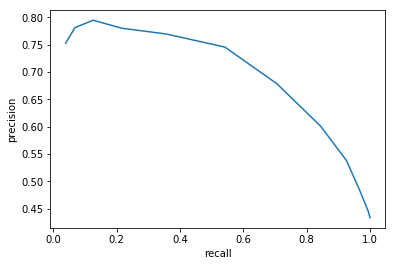

In [105]:
precisions = np.zeros(15)
recall = np.zeros(15)
for i in range(15):
    tprecision, trecall, tfscore = word_length_baseline(training_file, i)
    precisions[i] = tprecision
    recall[i] = trecall
    print("For threshold - {} the fscore is {}".format(i, tfscore))

plt.figure(1)
plt.plot(recall, precisions)
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

For threshold - 0 the fscore is 0.5895627644569816
For threshold - 1 the fscore is 0.5895627644569816
For threshold - 2 the fscore is 0.5895627644569816
For threshold - 3 the fscore is 0.5895627644569816
For threshold - 4 the fscore is 0.5971428571428571
For threshold - 5 the fscore is 0.6313364055299538
For threshold - 6 the fscore is 0.6791489361702128
For threshold - 7 the fscore is 0.7125984251968505
For threshold - 8 the fscore is 0.7065592635212887
For threshold - 9 the fscore is 0.624484181568088
For threshold - 10 the fscore is 0.4694214876033058
For threshold - 11 the fscore is 0.3500931098696462
For threshold - 12 the fscore is 0.2139917695473251
For threshold - 13 the fscore is 0.11013215859030837
For threshold - 14 the fscore is 0.05949656750572082


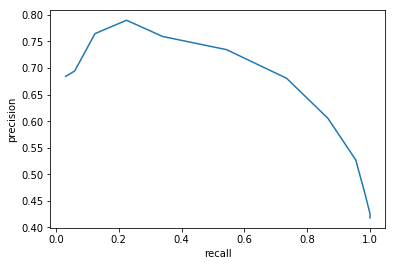

In [106]:
precisions = np.zeros(15)
recall = np.zeros(15)
for i in range(15):
    dprecision, drecall, dfscore = word_length_baseline(development_file, i)
    precisions[i] = dprecision
    recall[i] = drecall
    print("For threshold - {} the fscore is {}".format(i, dfscore))

plt.figure(2)
plt.plot(recall, precisions)
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

We can see that once the recall is big the precision is small and vice versa, that's because the two complement eachother. 

Now we can go about building the "ideal" threshold classifier:

In [102]:
## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def word_length_threshold(training_file, development_file):
    best_tfscore = 0.0
    best_i = 1
    i = 1
    while(True):
        tprecision, trecall, tfscore = word_length_baseline(training_file, i)
        if(tfscore < best_tfscore):
            break
        else:
            best_i = i
            i += 1
            best_tfscore = tfscore
            
    tprecision, trecall, tfscore = word_length_baseline(training_file, best_i)
    dprecision, drecall, dfscore = word_length_baseline(development_file, best_i)
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

In [103]:
training_performance, development_performance = word_length_threshold(training_file, development_file)
tr_precision, tr_recall, tr_fscore = training_performance
dv_precision, dv_recall, dv_fscore = development_performance
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}".format(tr_precision, tr_recall, tr_fscore))
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(dv_precision, dv_recall, dv_fscore))

Training Precision: 0.6007401315789473 
Training Recall: 0.8440207972270364 
Training Fscore: 0.7018976699495555
Dev Precision: 0.6053511705685619 
Dev Recall: 0.8660287081339713 
Dev Fscore: 0.7125984251968505


#### Part 1.2.3 - Word Frequency 